In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# **Read CSV File**

In [ ]:
data = pd.read_csv("GOOGL.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...,...
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700


# **Size Intialization**

In [ ]:
#Defining the size of every matrix like input weight matrix, hidden weight matrix and output matrix

#Here All 6 features are passed as an input to the model
input_size = 6
hidden_size = 10       #This is a hyperparameter changing the value of hidden size alter the convergence rate and final Training Loss
output_size = 6

# **Matrix Initialization**

In [ ]:
np.random.seed(0)
np.set_printoptions(suppress=True)
'''After generating random values in the range [0, 1], these values are then scaled to be in the range [-k, k].
The purpose of scaling the random values by 2*k - k is to center them around zero,
which can help with training stability.This can help prevent the activations from exploding or vanishing during training'''

k = 1/math.sqrt(hidden_size)
i_wt = np.random.rand(input_size, hidden_size)*2*k - k
h_wt = np.random.rand(hidden_size, hidden_size)*2*k - k
o_wt = np.random.rand(hidden_size, output_size)*2*k - k

h_bias = np.random.rand(1, hidden_size)*2*k - k
o_bias = np.random.rand(1,output_size)*2*k - k

# **Dataframe to Feature Matrix**

In [ ]:
#Converting Dataframe into input matrix

features = ['Date','Open', 'High', 'Low', 'Close','Adj Close','Volume']
a = len(features)
x = data[features].values
print(x)

[['2004-08-19' 50.050049 52.082081 ... 50.220219 50.220219 44659096]
 ['2004-08-20' 50.555557 54.594597 ... 54.209209 54.209209 22834343]
 ['2004-08-23' 55.430431 56.796799 ... 54.754753 54.754753 18256126]
 ...
 ['2022-03-22' 2722.030029 2821.0 ... 2797.360107 2797.360107 1774800]
 ['2022-03-23' 2774.050049 2791.77002 ... 2765.51001 2765.51001 1257700]
 ['2022-03-24' 2784.0 2832.379883 ... 2831.439941 2831.439941 1317900]]


In [ ]:
def mse_grad(actual,predicted):
  return (predicted - actual)

In [ ]:
def mse(actual,predicted):
  return np.mean((actual - predicted)**2)

# **Forward Pass**

In [ ]:
import numpy as np

def forward_prop(feature_matrix, matrices):
    # Unpack matrices
    i_wt, h_wt, h_bias, o_wt, o_bias = matrices

    # Get number of samples and total features
    num_samples = feature_matrix.shape[0]
    total_features = feature_matrix.shape[1] - 1  # Excluding the Date column

    # Initialize hidden and output arrays
    hidden = np.zeros((num_samples, hidden_size))
    output = np.zeros((num_samples, output_size))

    # Iterate over samples
    for i in range(num_samples):
        # Calculate the input to the hidden layer
        input_to_hidden = np.dot(feature_matrix[i, :], i_wt)

        # Calculate the hidden state using ReLU activation function
        if i == 0:
            hidden_state = np.maximum(0, input_to_hidden)  # ReLU activation
        else:
            hidden_state = np.maximum(0, input_to_hidden + np.dot(hidden[i-1, :], h_wt) + h_bias)  # ReLU activation

        # Store the hidden state
        hidden[i, :] = hidden_state

        # Calculate the output
        output[i, :] = np.dot(hidden_state, o_wt) + o_bias

    return hidden, output


# **Backward Pass**

In [ ]:
def backward_prop(feature_matrix, lr, grad, hidden, matrices, lambda_reg):
    # Unpack matrices
    i_wt, h_wt, h_bias, o_wt, o_bias = matrices

    # Get number of samples and total features
    num_samples = feature_matrix.shape[0]
    total_features = feature_matrix.shape[1] - 1  # Excluding the Date column

    # Initialize gradient matrices
    i_wt_grad = np.zeros((input_size, hidden_size))
    h_wt_grad = np.zeros((hidden_size, hidden_size))
    o_wt_grad = np.zeros((hidden_size, output_size))
    h_bias_grad = np.zeros((1, hidden_size))
    o_bias_grad = np.zeros((1, output_size))

    next_grad = None

    # Backpropagation loop
    for i in range(num_samples - 1, -1, -1):
        # Extract gradient for current time step
        out_grad = grad[i, :]

        # Update gradients for output weights and biases with L2 regularization
        o_wt_grad += np.dot(hidden[i].reshape(-1, 1), out_grad.reshape(1, -1)) + lambda_reg * o_wt
        o_bias_grad += out_grad

        # Calculate gradient for hidden layer
        h_grad = np.dot(out_grad, o_wt.T)
        if next_grad is not None:
            h_grad += np.dot(next_grad, h_wt.T)

        # Apply gradient for ReLU activation function
        relu_grad = np.where(hidden[i] > 0, 1, 0)
        h_grad = np.multiply(h_grad, relu_grad)
        next_grad = h_grad.copy()

        if i > 0:
            # Update gradients for hidden weights and biases with L2 regularization
            h_wt_grad += np.dot(hidden[i-1].reshape(-1, 1), h_grad.reshape(1, -1)) + lambda_reg * h_wt
            h_bias_grad += h_grad

        # Update gradient for input weights with L2 regularization
        i_wt_grad += np.dot(feature_matrix[i, :].reshape(-1, 1), h_grad.reshape(1, -1)) + lambda_reg * i_wt

    # Update weights and biases using gradient descent
    i_wt -= i_wt_grad * lr
    h_wt -= h_wt_grad * lr
    h_bias -= h_bias_grad * lr
    o_wt -= o_wt_grad * lr
    o_bias -= o_bias_grad * lr

    # Update matrices with new weights and biases
    matrices = [i_wt, h_wt, h_bias, o_wt, o_bias]

    return matrices


# **Creating Testing and Training Data**

In [ ]:
# Initialize lists for training and testing data
x_train = []
y_train = []
x_test = []
y_test = []
dates_train = []
dates_test = []

i = 0
while i < len(x):

    if x[i][0][:4] < '2021':

        x_train.append(x[i][1:])  # Append features to training data
        dates_train.append(x[i][0])
        # y_train.append([x[i][1],x[i][2],x[i][3],x[i][6]])
        y_train.append([x[i][1], x[i][2], x[i][3], x[i][4], x[i][5], x[i][6]])  # Append labels to training data
    else:

        x_test.append(x[i][1:])  # Append features to testing data
        dates_test.append(x[i][0])
        # y_test.append([x[i][1],x[i][2],x[i][3],x[i][6]])
        y_test.append([x[i][1], x[i][2], x[i][3], x[i][4], x[i][5], x[i][6]])  # Append labels to testing data
    i += 1

# Print lengths and the first entry of the training data
print("Number of entries in training data:", len(x_train))
print("Number of entries in testing data:", len(x_test))
print("First entry in the training data:", x_train[0])


Number of entries in training data: 4122
Number of entries in testing data: 309
First entry in the training data: [50.050049 52.082081 48.028027 50.220219 50.220219 44659096]


# **Feature Scaling**

In [ ]:
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
y_train_norm = scaler.fit_transform(y_train)
x_test_norm = scaler.fit_transform(x_test)
y_test_norm = scaler.fit_transform(y_test)

# **Training Loop**

In [ ]:
matrices = [i_wt,h_wt,h_bias,o_wt,o_bias]
test_error = []

lr = 0.001    #Learning rate another Hyperparameter
epochs = 50
seq_len = 15   #Hyperparameter : lenth of the RNN sequence

for epoch in range(epochs):
  epoch_loss = 0
  for i in range(len(x_train_norm) - seq_len):
    seq_x = np.array(x_train_norm[i:(i + seq_len)])
    seq_y = np.array(y_train_norm[i:(i + seq_len)])

    hidden,output = forward_prop(seq_x , matrices)
    grad = mse_grad(seq_y , output)
    matrices = backward_prop(seq_x,lr,grad,hidden,matrices,0.0001)

    epoch_loss += mse(seq_y,output)
  test_error.append(epoch_loss)

  print(f'Epoch {epoch + 1} loss is {epoch_loss}')

Epoch 1 loss is 28.371037627294694
Epoch 2 loss is 8.887995951053707
Epoch 3 loss is 2.862831207095385
Epoch 4 loss is 2.073795456682424
Epoch 5 loss is 1.6080145265781645
Epoch 6 loss is 2.9954855542354006
Epoch 7 loss is 1.6722250929438411
Epoch 8 loss is 1.2080962807260431
Epoch 9 loss is 0.9614541422218388
Epoch 10 loss is 0.7832533571587309
Epoch 11 loss is 0.7096206903629153
Epoch 12 loss is 0.6456413193690539
Epoch 13 loss is 0.6147560465768256
Epoch 14 loss is 0.5905948923690886
Epoch 15 loss is 0.5709862345745897
Epoch 16 loss is 0.5581799017353547
Epoch 17 loss is 0.5453092775651741
Epoch 18 loss is 0.5348644300771423
Epoch 19 loss is 0.5243002918566667
Epoch 20 loss is 0.5157555195875299
Epoch 21 loss is 0.508050095261201
Epoch 22 loss is 0.5008082921879529
Epoch 23 loss is 0.49358244398497764
Epoch 24 loss is 0.4868219604445658
Epoch 25 loss is 0.4806774139769175
Epoch 26 loss is 0.47596331195387725
Epoch 27 loss is 0.47034327692216316
Epoch 28 loss is 0.4651150463572375
Ep

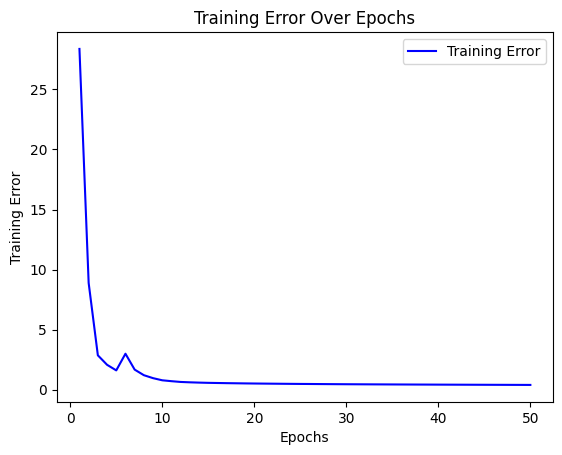

In [ ]:
epochs = range(1, len(test_error) + 1)

plt.plot(epochs, test_error, 'b', label='Training Error')
plt.title('Training Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.legend()
plt.show()

# **Predicting From the Data**

In [ ]:
predictions = []  # List to store predictions for x_test

# Loop over the x_test data
for i in range(len(x_test) - seq_len + 1):
    seq_x_test = np.array(x_test_norm[i:(i + seq_len)])
    hidden, output = forward_prop(seq_x_test, matrices)

    if i == 0:
        predictions.extend(output)
    else:
        predictions.append(output[-1])

# Convert predictions to a NumPy array
predictions = np.array(predictions)
print("Predicted values for the future:")
print(predictions)


Predicted values for the future:
[[-2.25346022 -2.29301276 -2.18001927 -2.18854624 -2.1735004   0.85501631]
 [-2.27448306 -2.3382375  -2.18042664 -2.19788252 -2.21212553 -0.48088851]
 [-2.32291429 -2.38046303 -2.22831308 -2.25997542 -2.26745428  1.26490682]
 ...
 [ 0.7321254   0.7472872   0.67906262  0.72685764  0.71675876  0.21743951]
 [ 0.71531685  0.7086865   0.70881819  0.72711453  0.72000031 -0.53050957]
 [ 0.82332531  0.82444419  0.81010399  0.83122217  0.82439388 -0.40917832]]


# **Predicting Using Forecasting Technique**

In [ ]:
initial_sequence = x_test_norm[: seq_len]

# List to store predicted values
predicted_values = [value for value in initial_sequence]


# Perform forecasting for a certain number of time steps into the future
num_forecast_steps = 309 - seq_len

for i in range(num_forecast_steps):

    hidden, output = forward_prop(initial_sequence, matrices)

    # Append the predicted value to the list of predicted values
    predicted_values.append(output[-1])

    # Update the initial sequence by appending the predicted value and discarding the oldest value
    initial_sequence = np.concatenate((initial_sequence[1:], output[-1][np.newaxis,:]))

# Convert the list of predicted values to a NumPy array
predicted_forecast_values = np.array(predicted_values)
print("Predicted values for the future:")
print((predicted_forecast_values))


Predicted values for the future:
[[-2.20547422 -2.27228767 -2.31271317 -2.32268484 -2.32268484  0.36369169]
 [-2.306064   -2.31746571 -2.28421718 -2.28223924 -2.28223924 -0.85035932]
 [-2.37760904 -2.32571655 -2.34494643 -2.33212793 -2.33212793  1.02668206]
 ...
 [ 0.19163748  0.20464382  0.16218877  0.18676158  0.18226228 -0.06676745]
 [ 0.19853049  0.21150224  0.16880532  0.1935958   0.18905313 -0.06384109]
 [ 0.20544931  0.21838634  0.17544664  0.2004556   0.19586941 -0.06090377]]


# **Converting Back to Original Scale**

In [ ]:
predictions_original_scale = scaler.inverse_transform(predictions)
predictions_forecast_original_scale = scaler.inverse_transform(predicted_forecast_values)

# **Comparing Actual and Predicted Graph**

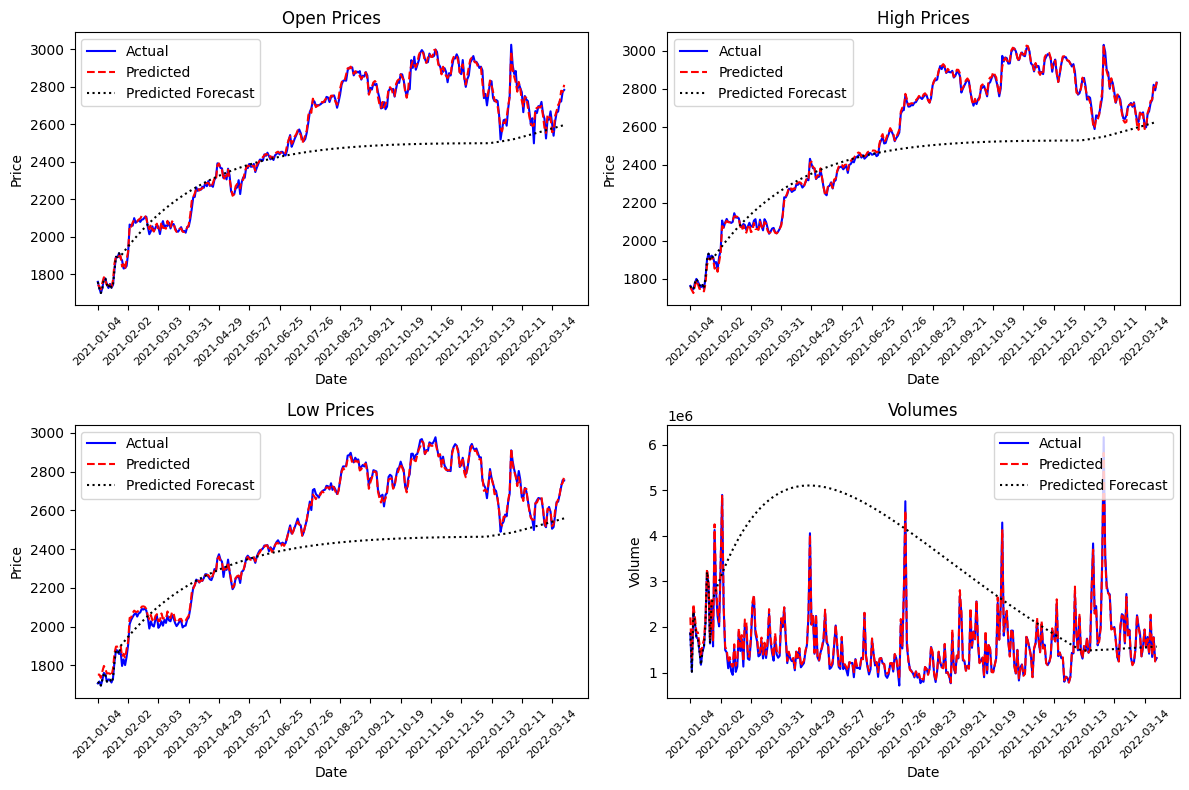

In [ ]:
# Extracting dates and stock prices from training data
start_index = 0
end_index = 309
gap = 20

dates = dates_test[start_index:end_index]
open_prices = [entry[0] for entry in x_test][start_index:end_index]
high_prices = [entry[1] for entry in x_test][start_index:end_index]
low_prices = [entry[2] for entry in x_test][start_index:end_index]
volumes = [entry[5] for entry in x_test][start_index:end_index]

open_prices_predicted = [entry[0] for entry in predictions_original_scale][start_index:end_index]
high_prices_predicted = [entry[1] for entry in predictions_original_scale][start_index:end_index]
low_prices_predicted = [entry[2] for entry in predictions_original_scale][start_index:end_index]
volumes_predicted = [entry[5] for entry in predictions_original_scale][start_index:end_index]

open_prices_predicted_forecast = [entry[0] for entry in predictions_forecast_original_scale][start_index:end_index]
high_prices_predicted_forecast = [entry[1] for entry in predictions_forecast_original_scale][start_index:end_index]
low_prices_predicted_forecast = [entry[2] for entry in predictions_forecast_original_scale][start_index:end_index]
volumes_predicted_forecast = [entry[5] for entry in predictions_forecast_original_scale][start_index:end_index]

# Plotting the data
plt.figure(figsize=(12, 8))

# Open Prices
plt.subplot(2, 2, 1)
plt.plot(dates, open_prices, color='blue', label='Actual')
plt.plot(dates, open_prices_predicted, color='red', linestyle='--', label='Predicted')
plt.plot(dates, open_prices_predicted_forecast, color='black', linestyle=':', label='Predicted Forecast')
plt.title('Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(dates[::gap], rotation=45, fontsize=8)
plt.legend()

# High Prices
plt.subplot(2, 2, 2)
plt.plot(dates, high_prices, color='blue', label='Actual')
plt.plot(dates, high_prices_predicted, color='red', linestyle='--', label='Predicted')
plt.plot(dates, high_prices_predicted_forecast, color='black', linestyle=':', label='Predicted Forecast')
plt.title('High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(dates[::gap], rotation=45, fontsize=8)
plt.legend()

# Low Prices
plt.subplot(2, 2, 3)
plt.plot(dates, low_prices, color='blue', label='Actual')
plt.plot(dates, low_prices_predicted, color='red', linestyle='--', label='Predicted')
plt.plot(dates, low_prices_predicted_forecast, color='black', linestyle=':', label='Predicted Forecast')
plt.title('Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(dates[::gap], rotation=45, fontsize=8)
plt.legend()

# Volumes
plt.subplot(2, 2, 4)
plt.plot(dates, volumes, color='blue', label='Actual')
plt.plot(dates, volumes_predicted, color='red', linestyle='--', label='Predicted')
plt.plot(dates, volumes_predicted_forecast, color='black', linestyle=':', label='Predicted Forecast')
plt.title('Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(dates[::gap], rotation=45, fontsize=8)
plt.legend()

plt.tight_layout()
plt.show()


# **Calculating MSE Loss**

In [ ]:
#Keeping the parameters as following:


#learning rate = 0.001
#epochs = 50
#seq_len = 15
#Hidden Size = 10
#Activation fuction = relu

mse1 = mean_squared_error(y_test_norm, predictions)
mse2 = mean_squared_error(y_test_norm, predicted_forecast_values)


print("Mean Squared Error:", mse1)
print("Mean Squared Error:", mse2)

Mean Squared Error: 0.003953489205359721
Mean Squared Error: 2.237520657003364
